In [1]:
import torch
import numpy as np
import os
from torch import nn
import sys
import polars as pl
import sklearn
import shap
from functools import partial
import pandas as pd
import random
from matplotlib import pyplot as plt
import time
from rdkit.Chem import DataStructs
from tqdm import tqdm
from joblib import Parallel, delayed
import math
sys.path.append('../')

In [2]:
CLASS_IDXS = [0, 1, 2]
CLASS_IDX = 0
# SAVE_DIR = '/home/dangnh36/datasets/competitions/leash_belka/processed/feature_importance/public_nonshare-mlp-ecfp6-bb_grid-scaffold_5_8_2_3_shuffle_5.8M'

SAVE_DIR = '/home/dangnh36/datasets/competitions/leash_belka/processed/feature_importance/public_nonshare-mlp-ecfp6-bb_grid-scaffold_gkf_5_8_2_2_shuffle_2.0M'

DEBUG = False

DEVICE = torch.device('cuda:2')
DEVICE

device(type='cuda', index=2)

In [3]:
test_df = pl.scan_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/test_v4.csv').with_row_index('index').select(
#         pl.col('molecule'),
        pl.col('index', 'mol_group'),
#         pl.col('bb1', 'bb2', 'bb3').cast(pl.UInt16),
        # pl.col('BRD4', 'HSA', 'sEH').cast(pl.UInt8),
    ).collect()
print(test_df.estimated_size('gb'), 'GB')
test_df.group_by('mol_group').count().sort('mol_group')

0.00981266051530838 GB


/tmp/ipykernel_28584/361753753.py:8: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  test_df.group_by('mol_group').count().sort('mol_group')


mol_group,count
i64,u32
0,369039
1,486390
2,11271
3,11322


In [8]:
test_df

index,mol_group
u32,i64
0,2
1,2
2,2
3,2
4,2
…,…
878017,0
878018,0
878019,0


In [4]:
369039 + 486390 + 11271 + 11322

878022

In [6]:
TRAIN_LEN = 98_415_610
idxs = [np.arange(0, TRAIN_LEN, 1)]

# ┌───────────┬────────┐
# │ mol_group ┆ count  │
# │ ---       ┆ ---    │
# │ i64       ┆ u32    │
# ╞═══════════╪════════╡
# │ 0         ┆ 369039 │
# │ 1         ┆ 486390 │
# │ 2         ┆ 11271  │
# │ 3         ┆ 11322  │
# └───────────┴────────┘

group_ids = [0, 1, 2, 3]
group_weights = [1, 25, 280, 280]
for group_id, group_weight in zip(group_ids, group_weights):
    print(group_id)
    group_idxs = test_df.filter(pl.col('mol_group') == group_id)['index'].to_numpy()
    idxs.extend([group_idxs] * group_weight)

print([e.shape for e in idxs])


0
1
2
3
[(98415610,), (369039,), (486390,), (486390,), (486390,), (486390,), (486390,), (486390,), (486390,), (486390,), (486390,), (486390,), (486390,), (486390,), (486390,), (486390,), (486390,), (486390,), (486390,), (486390,), (486390,), (486390,), (486390,), (486390,), (486390,), (486390,), (486390,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (11271,), (1

In [7]:
idxs = np.concatenate(idxs, axis = 0)
idxs.shape

(117270439,)

In [4]:
test_data = np.load('/home/dangnh36/datasets/competitions/leash_belka/processed/features/ecfp6/test.npy', mmap_mode='r')
nonshare_test_idxs = test_df.filter(pl.col('mol_group') == 2)['index']
test_features = test_data[nonshare_test_idxs]
test_features = np.unpackbits(test_features, axis = -1)
test_features.shape

(11271, 2048)

In [5]:
from torch import nn
from torch import nn
import torch
import logging
from functools import partial
from transformers import AutoConfig, AutoTokenizer, AutoModel, DataCollatorWithPadding
from transformers import RobertaModel, RobertaConfig
from src.modules import layers
from src.modules.misc import get_act_fn

NORMS = {'LN': nn.LayerNorm, 'BN': nn.BatchNorm1d}


def arr_to_fp(arr):
    bitstring="".join(arr.astype(str))
    fp = DataStructs.cDataStructs.CreateFromBitString(bitstring)
    return fp

class MlpModel(nn.Module):

    def __init__(self, global_cfg, class_idx = None):
        super().__init__()
        cfg = global_cfg.model
        self.class_idx = class_idx
        self.mlp = layers.MLP(
            cfg.in_dim,
            cfg.mlp_chans + [3],
            norm_layer=NORMS[cfg.norm] if cfg.norm is not None else None,
            act_layer=get_act_fn(cfg.act),
            dropout=cfg.dropout,
            last_norm=False,
            last_activation=False,
            last_dropout=False)

    def forward(self, x, padding_mask=None):
        x = self.mlp(x.float())
        if self.class_idx is None:
            return x
        else:
            return x[:, self.class_idx:self.class_idx+1]
    
    
def get_mlp_model(weight_path = None, class_idx = None, device = DEVICE):
    from types import SimpleNamespace
    global_cfg = SimpleNamespace(**{})
    model_cfg = SimpleNamespace(**{})
    global_cfg.model = model_cfg

    model_cfg.in_dim = 2048
    model_cfg.mlp_chans = [512, 512]
    model_cfg.norm = None
    model_cfg.act = 'gelu'
    model_cfg.dropout = 0.3
    model = MlpModel(global_cfg, class_idx = class_idx)
    if weight_path is not None:
        ckpt = torch.load(weight_path, map_location = 'cpu')
        ckpt = {k.replace('model.', '', 1): v for k, v in ckpt['state_dict'].items()}
        model.load_state_dict(ckpt, strict=True)
    model = model.to(DEVICE).eval()
    return model


def get_feature_importance(shap_values, feature_names = None):
    assert shap_values.ndim == 2
    if feature_names is not None:
        assert len(feature_names) == shap_values.shape[1]
    feat_importances = np.abs(shap_values).mean(0)
    feat_importances_df = pd.DataFrame({'feature': feature_names, 'importance': feat_importances}).sort_values('importance', ascending=False)
    return feat_importances_df


@torch.inference_mode()
def mlp_predict(x, model, class_idx = 0, bs = 2**14):
    ret = np.zeros((x.shape[0],), dtype = np.float32)
    for start in range(0, x.shape[0], bs):
        inp = torch.from_numpy(x[start:start + bs]).float().to('cuda:2')
        logit = model(inp)
        logit = logit[:, class_idx].cpu().numpy()
        ret[start:start + bs] = logit
    return ret


def get_sweep_ckpt_paths(root_dir):
    ret = []
    run_dirs = [os.path.join(root_dir, e) for e in os.listdir(root_dir)]
    run_dirs = sorted([e for e in run_dirs if os.path.isdir(e)])
    for run_dir in run_dirs:
        sub_dirs = os.listdir(run_dir)
        sub_dirs = [e for e in sub_dirs if 'fold_' in e]
        assert len(sub_dirs) == 1
        sub_dir = sub_dirs[0]
        fold_idx = int(sub_dir.replace('fold_', ''))
        ckpt_path = os.path.join(run_dir, sub_dir, 'ckpts', 'last.ckpt')
        assert os.path.isfile(ckpt_path)
        ret.append([fold_idx, ckpt_path])
    ret.sort(key = lambda x: x[0])
    return ret

In [6]:
# ckpt_paths = get_sweep_ckpt_paths(
#     '/home/dangnh36/projects/competitions/kaggle_leash_belka/src/outputs/train/multirun/06-17/08-36-00.533707_pregen-ecfp6-02_mlp/') + \
#     get_sweep_ckpt_paths(
#     '/home/dangnh36/projects/competitions/kaggle_leash_belka/src/outputs/train/multirun/06-17/08-36-28.828748_pregen-ecfp6-02_mlp/')


ckpt_paths = get_sweep_ckpt_paths(
    '/home/dangnh36/projects/competitions/kaggle_leash_belka/src/outputs/train/multirun/06-14/15-25-27.097692_pregen-ecfp6-02_mlp/')

ckpt_paths.sort(key = lambda x: x[0])
ckpt_paths = [e[1] for e in ckpt_paths]
ckpt_paths

['/home/dangnh36/projects/competitions/kaggle_leash_belka/src/outputs/train/multirun/06-14/15-25-27.097692_pregen-ecfp6-02_mlp/0_callbacks.early_stopping.patience=2,cv.fold_idx=0,cv.strategy=bb_grid-scaffold_gkf_5_8_2_2_shuffle_2.0M,exp=pregen_fp_mlp,exp_name=pregen-ecfp6-02_mlp,optim.lr=0.0005,optim.weight_decay=0.0,trainer.check_val_every_n_epoch=5,trainer.max_epochs=40,tr_ETC_/fold_0/ckpts/last.ckpt',
 '/home/dangnh36/projects/competitions/kaggle_leash_belka/src/outputs/train/multirun/06-14/15-25-27.097692_pregen-ecfp6-02_mlp/1_callbacks.early_stopping.patience=2,cv.fold_idx=1,cv.strategy=bb_grid-scaffold_gkf_5_8_2_2_shuffle_2.0M,exp=pregen_fp_mlp,exp_name=pregen-ecfp6-02_mlp,optim.lr=0.0005,optim.weight_decay=0.0,trainer.check_val_every_n_epoch=5,trainer.max_epochs=40,tr_ETC_/fold_1/ckpts/last.ckpt',
 '/home/dangnh36/projects/competitions/kaggle_leash_belka/src/outputs/train/multirun/06-14/15-25-27.097692_pregen-ecfp6-02_mlp/2_callbacks.early_stopping.patience=2,cv.fold_idx=2,cv.st

# Clustering

In [7]:
test_fps = [arr_to_fp(fp) for fp in tqdm(test_features)]
len(test_fps)

100%|███████████████████████████████████| 11271/11271 [00:16<00:00, 674.33it/s]


11271

In [8]:
def do_clustering(fps, threshold = 0.6):
    from rdkit import Chem, DataStructs
    from rdkit.Chem import AllChem
    from rdkit.ML.Cluster import Butina
            
    if isinstance(fps, np.ndarray):
        fps = [arr_to_fp(fp) for fp in tqdm(fps)]
    dists = []
    nfps = len(fps)
    for i in tqdm(range(1, nfps)):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps[:i])
        dists.extend([1 - x for x in sims])
    clusters = Butina.ClusterData(dists,
                               nfps,
                               threshold,
                               isDistData=True)
    return clusters


def pickup_cluster_elements(cluster_idxs, all_fps, n):
    """Pickup a diverse set of n samples within a cluster,
    heuristically maximize pair-wise distance"""
    centroid_idx = cluster_idxs[0]
    cluster_fps = [all_fps[i] for i in cluster_idxs]
    selected_idxs = [centroid_idx]
    for _ in range(1, n):
        dists = []
        for selected_idx in selected_idxs:
            sims = DataStructs.BulkTanimotoSimilarity(all_fps[selected_idx], cluster_fps)
            dist = np.array([1 - x for x in sims])
            dists.append(dist)
        dists = np.array(dists)
        dists = dists.mean(axis = 0)
        assert dists.shape[0] == len(cluster_idxs) and len(dists.shape) == 1
        dists[[cluster_idxs.index(e) for e in selected_idxs]] = -9999. # ignore
        next_selected_idx = cluster_idxs[np.argmax(dists)]
#         print(f'{_} -> {next_selected_idx} with cost {dists[np.argmax(dists)]} (min={np.min(dists)})')
        selected_idxs.append(next_selected_idx)
    return selected_idxs

In [9]:
clusters = do_clustering(test_fps, threshold = 0.5)
print('NUM CLUSTERS:', len(clusters))
clusters = {cluster_idx: cluster for cluster_idx, cluster in enumerate(sorted(clusters, key = lambda x: -len(x)))}
print(clusters)
print([len(v) for v in clusters.values()])

100%|███████████████████████████████████| 11270/11270 [00:25<00:00, 444.81it/s]


NUM CLUSTERS: 292
{0: (10990, 382, 1045, 1370, 1447, 1502, 1619, 1659, 1689, 1703, 1708, 1709, 1710, 1712, 1714, 1717, 3697, 4360, 4685, 4934, 5018, 5023, 5027, 5686, 6349, 7675, 8338, 9664, 9989, 10121, 10238, 10308, 10322, 10327, 10328, 10329, 10331, 10608, 10610, 10612, 10614, 10615, 10617, 10619, 10620, 10621, 10622, 10623, 10625, 10628, 10630, 10635, 10636, 10639, 10642, 10644, 10645, 10646, 10647, 10648, 10649, 10650, 10651, 10652, 10653, 10654, 10655, 10656, 10657, 10658, 10659, 10660, 10661, 10662, 10663, 10664, 10669, 10670, 10676, 10679, 10682, 10693, 10695, 10704, 10705, 10722, 10724, 10725, 10726, 10727, 10729, 10730, 10732, 10733, 10734, 10735, 10740, 10744, 10746, 10749, 10754, 10757, 10760, 10767, 10768, 10769, 10770, 10771, 10772, 10773, 10774, 10775, 10776, 10777, 10778, 10779, 10780, 10781, 10782, 10783, 10784, 10785, 10786, 10787, 10788, 10789, 10790, 10791, 10792, 10793, 10794, 10795, 10796, 10797, 10798, 10799, 10801, 10803, 10804, 10808, 10810, 10812, 10814, 10815

In [10]:
pickup_cluster_elements(clusters[0], all_fps=test_fps, n = 10)

[10990, 1447, 11268, 11023, 10329, 10959, 10935, 6349, 11002, 4685]

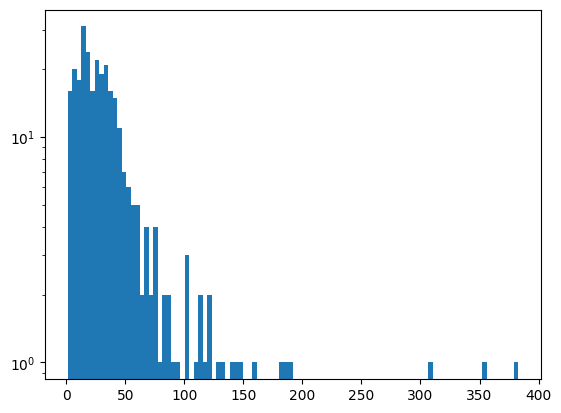

In [11]:
plt.hist([len(v) for v in clusters.values()], log = True, bins = 100)
plt.show()

In [12]:
selected_idxs = []
for cluster_idx, cluster in clusters.items():
    n = max(1, len(cluster) // 30)
    print(cluster_idx, n)
    selected_idxs.extend(pickup_cluster_elements(cluster, test_fps, n = n))
print('NUM SELECTED:', len(selected_idxs))
print(selected_idxs)

0 12
1 11
2 10
3 6
4 6
5 6
6 5
7 4
8 4
9 4
10 4
11 4
12 4
13 4
14 3
15 3
16 3
17 3
18 3
19 3
20 3
21 3
22 2
23 2
24 2
25 2
26 2
27 2
28 2
29 2
30 2
31 2
32 2
33 2
34 2
35 2
36 2
37 2
38 2
39 2
40 2
41 2
42 1
43 1
44 1
45 1
46 1
47 1
48 1
49 1
50 1
51 1
52 1
53 1
54 1
55 1
56 1
57 1
58 1
59 1
60 1
61 1
62 1
63 1
64 1
65 1
66 1
67 1
68 1
69 1
70 1
71 1
72 1
73 1
74 1
75 1
76 1
77 1
78 1
79 1
80 1
81 1
82 1
83 1
84 1
85 1
86 1
87 1
88 1
89 1
90 1
91 1
92 1
93 1
94 1
95 1
96 1
97 1
98 1
99 1
100 1
101 1
102 1
103 1
104 1
105 1
106 1
107 1
108 1
109 1
110 1
111 1
112 1
113 1
114 1
115 1
116 1
117 1
118 1
119 1
120 1
121 1
122 1
123 1
124 1
125 1
126 1
127 1
128 1
129 1
130 1
131 1
132 1
133 1
134 1
135 1
136 1
137 1
138 1
139 1
140 1
141 1
142 1
143 1
144 1
145 1
146 1
147 1
148 1
149 1
150 1
151 1
152 1
153 1
154 1
155 1
156 1
157 1
158 1
159 1
160 1
161 1
162 1
163 1
164 1
165 1
166 1
167 1
168 1
169 1
170 1
171 1
172 1
173 1
174 1
175 1
176 1
177 1
178 1
179 1
180 1
181 1
182 1
183 1
184

In [13]:
background_features = test_features[selected_idxs]
background_features.shape

(398, 2048)

In [14]:
def analyze_feature_importance(model, features, backgrounds, method = 'gradient', device = 'cuda:0'):
    device = torch.device(device)
    if method == 'gradient':
        features_tensor = torch.from_numpy(features).float().to(device)
        background_tensor = torch.from_numpy(backgrounds).float().to(device)
        explainer = shap.GradientExplainer(model.to(device).eval(),
                                           background_tensor,
                                           batch_size=4096,
                                           local_smoothing=0)
        shap_values = explainer.shap_values(features_tensor, nsamples=200)
        if len(shap_values.shape) > 2:
            old_shape = shap_values.shape
            shap_values = shap_values[..., 0]
            print(old_shape, '-->', shap_values.shape)
            
    else:
        raise NotImplementedError
    
    feat_imp_df = get_feature_importance(shap_values, [f'ECFP6_{i}' for i in range(2048)])
    print('SUM:', feat_imp_df['importance'].sum())
    print('NUMBER OF > 0:', len(feat_imp_df.query('importance > 0')))
    
    return shap_values, feat_imp_df

In [15]:
%%time
if DEBUG:
    model = get_mlp_model(ckpt_paths[0], class_idx = 1, device = DEVICE)
    print(model)
    shap_values, feat_imp_df = analyze_feature_importance(model, test_features[:50], background_features)
    display(feat_imp_df)

CPU times: user 13 µs, sys: 1 µs, total: 14 µs
Wall time: 26.5 µs


In [16]:
def process_one_fold(fold_idx, ckpt_path, class_idx, features, backgrounds, save_root_dir, device = DEVICE):
    print(f'---Processing fold {fold_idx}---')
    model = get_mlp_model(ckpt_path, class_idx = class_idx, device = device)
    print(model)
    start = time.time()
    shap_values, feat_imp_df = analyze_feature_importance(model, features, backgrounds,
                                                          method = 'gradient', device = device)
    end = time.time()
    print('TAKE TIME:', fold_idx, end - start, 's')
    save_imp_dir = os.path.join(save_root_dir, str(class_idx), 'importance')
    save_shap_dir = os.path.join(save_root_dir, str(class_idx), 'shap')
    os.makedirs(save_imp_dir, exist_ok=True)
    os.makedirs(save_shap_dir, exist_ok=True)
    np.save(os.path.join(save_shap_dir, f'{fold_idx}.npy'), shap_values)
    feat_imp_df.to_csv(os.path.join(save_imp_dir, f'{fold_idx}.csv'), index = False)
    return shap_values, feat_imp_df

In [17]:
test_features.shape, background_features.shape

((11271, 2048), (398, 2048))

In [18]:
devices = ['cuda:0'] * 10 + ['cuda:1'] * 10 + ['cuda:2'] * 10 + ['cuda:3'] * 10
print(devices)

['cuda:0', 'cuda:0', 'cuda:0', 'cuda:0', 'cuda:0', 'cuda:0', 'cuda:0', 'cuda:0', 'cuda:0', 'cuda:0', 'cuda:1', 'cuda:1', 'cuda:1', 'cuda:1', 'cuda:1', 'cuda:1', 'cuda:1', 'cuda:1', 'cuda:1', 'cuda:1', 'cuda:2', 'cuda:2', 'cuda:2', 'cuda:2', 'cuda:2', 'cuda:2', 'cuda:2', 'cuda:2', 'cuda:2', 'cuda:2', 'cuda:3', 'cuda:3', 'cuda:3', 'cuda:3', 'cuda:3', 'cuda:3', 'cuda:3', 'cuda:3', 'cuda:3', 'cuda:3']


In [19]:
if DEBUG:
    shap_values, feat_imp_df = process_one_fold(0,
                     ckpt_paths[0],
                     class_idx = CLASS_IDX,
                     features=test_features[:50],
                     backgrounds=background_features,
                    save_root_dir = SAVE_DIR,
                    device = 'cuda:1')

In [20]:
ret = {}
for class_idx in CLASS_IDXS:
    print('Processing class', class_idx)
    ret[class_idx] = Parallel(n_jobs=len(ckpt_paths), backend='loky')(
        delayed(process_one_fold)(i,
                                 ckpt_paths[i],
                                 class_idx = class_idx,
                                 features = test_features,
                                 backgrounds = background_features,
                                 save_root_dir = SAVE_DIR,
                                 device = devices[i])
                for i in tqdm(range(len(ckpt_paths))))
print([len(v) for v in ret.values()])

Processing class 0


100%|██████████████████████████████████████████| 40/40 [00:01<00:00, 22.99it/s]
/tmp/ipykernel_59638/1858804327.py:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987394225/work/torch/csrc/utils/tensor_numpy.cpp:206.)
/tmp/ipykernel_59638/1858804327.py:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/c

/tmp/ipykernel_59638/1858804327.py:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987394225/work/torch/csrc/utils/tensor_numpy.cpp:206.)
/tmp/ipykernel_59638/1858804327.py:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987394225/work/torch/csrc/utils/tensor_numpy.cpp:206.)
/tmp

/tmp/ipykernel_59638/1858804327.py:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987394225/work/torch/csrc/utils/tensor_numpy.cpp:206.)
/tmp/ipykernel_59638/1858804327.py:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987394225/work/torch/csrc/utils/tensor_numpy.cpp:206.)
/tmp

---Processing fold 28---
MlpModel(
  (mlp): MLP(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=3, bias=True)
  )
)
(11271, 2048, 1) --> (11271, 2048)
SUM: 92.12654185043674
NUMBER OF > 0: 822
TAKE TIME: 28 1599.623901605606 s
---Processing fold 29---
MlpModel(
  (mlp): MLP(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=3, bias=True)
  )
)
(11271, 2048, 1) --> (11271, 2048)
SUM: 104.43575843145892
NUMBER OF > 0: 822
TAKE TIME: 29 1608.9987320899963 s
---P

---Processing fold 2---
MlpModel(
  (mlp): MLP(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=3, bias=True)
  )
)
(11271, 2048, 1) --> (11271, 2048)
SUM: 61.333226433718536
NUMBER OF > 0: 822
TAKE TIME: 2 2230.5193009376526 s
---Processing fold 23---
MlpModel(
  (mlp): MLP(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=3, bias=True)
  )
)
(11271, 2048, 1) --> (11271, 2048)
SUM: 79.06273784714128
NUMBER OF > 0: 822
TAKE TIME: 23 2232.960779905319 s
---Pro

100%|██████████████████████████████████████████| 40/40 [00:06<00:00,  5.85it/s]
/tmp/ipykernel_59638/1858804327.py:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987394225/work/torch/csrc/utils/tensor_numpy.cpp:206.)
/tmp/ipykernel_59638/1858804327.py:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/c

/tmp/ipykernel_59638/1858804327.py:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987394225/work/torch/csrc/utils/tensor_numpy.cpp:206.)
/tmp/ipykernel_59638/1858804327.py:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987394225/work/torch/csrc/utils/tensor_numpy.cpp:206.)
/tmp

---Processing fold 24---
MlpModel(
  (mlp): MLP(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=3, bias=True)
  )
)
(11271, 2048, 1) --> (11271, 2048)
SUM: 52.26982735599137
NUMBER OF > 0: 822
TAKE TIME: 24 1632.3542647361755 s
---Processing fold 38---
MlpModel(
  (mlp): MLP(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=3, bias=True)
  )
)
(11271, 2048, 1) --> (11271, 2048)
SUM: 40.755449079770436
NUMBER OF > 0: 822
TAKE TIME: 38 1646.2633345127106 s
---

---Processing fold 7---
MlpModel(
  (mlp): MLP(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=3, bias=True)
  )
)
(11271, 2048, 1) --> (11271, 2048)
SUM: 48.67351627394754
NUMBER OF > 0: 822
TAKE TIME: 7 1845.948725938797 s
---Processing fold 22---
MlpModel(
  (mlp): MLP(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=3, bias=True)
  )
)
(11271, 2048, 1) --> (11271, 2048)
SUM: 53.34164542188267
NUMBER OF > 0: 822
TAKE TIME: 22 2201.785763025284 s
---Proce

---Processing fold 27---
MlpModel(
  (mlp): MLP(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=3, bias=True)
  )
)
(11271, 2048, 1) --> (11271, 2048)
SUM: 57.74637829237641
NUMBER OF > 0: 822
TAKE TIME: 27 2538.3814237117767 s
---Processing fold 36---
MlpModel(
  (mlp): MLP(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=3, bias=True)
  )
)
(11271, 2048, 1) --> (11271, 2048)
SUM: 65.84040691296566
NUMBER OF > 0: 822
TAKE TIME: 36 2546.6289613246918 s
---P

100%|██████████████████████████████████████████| 40/40 [00:14<00:00,  2.71it/s]
/tmp/ipykernel_59638/1858804327.py:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987394225/work/torch/csrc/utils/tensor_numpy.cpp:206.)
/tmp/ipykernel_59638/1858804327.py:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/c

/tmp/ipykernel_59638/1858804327.py:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987394225/work/torch/csrc/utils/tensor_numpy.cpp:206.)
/tmp/ipykernel_59638/1858804327.py:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987394225/work/torch/csrc/utils/tensor_numpy.cpp:206.)
/tmp

/tmp/ipykernel_59638/1858804327.py:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987394225/work/torch/csrc/utils/tensor_numpy.cpp:206.)
/tmp/ipykernel_59638/1858804327.py:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987394225/work/torch/csrc/utils/tensor_numpy.cpp:206.)


---Processing fold 17---
MlpModel(
  (mlp): MLP(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=3, bias=True)
  )
)
(11271, 2048, 1) --> (11271, 2048)
SUM: 52.57212419749519
NUMBER OF > 0: 822
TAKE TIME: 17 6727.289125919342 s
---Processing fold 0---
MlpModel(
  (mlp): MLP(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=3, bias=True)
  )
)
(11271, 2048, 1) --> (11271, 2048)
SUM: 70.84822974556938
NUMBER OF > 0: 822
TAKE TIME: 0 1546.1295218467712 s
---Proc

---Processing fold 37---
MlpModel(
  (mlp): MLP(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=3, bias=True)
  )
)
(11271, 2048, 1) --> (11271, 2048)
SUM: 87.2416876418527
NUMBER OF > 0: 822
TAKE TIME: 37 2428.272102355957 s
---Processing fold 23---
MlpModel(
  (mlp): MLP(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=3, bias=True)
  )
)
(11271, 2048, 1) --> (11271, 2048)
SUM: 86.91788516752781
NUMBER OF > 0: 822
TAKE TIME: 23 2444.4709668159485 s
---Pro

---Processing fold 16---
MlpModel(
  (mlp): MLP(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=3, bias=True)
  )
)
(11271, 2048, 1) --> (11271, 2048)
SUM: 73.83467667746133
NUMBER OF > 0: 822
TAKE TIME: 16 5412.995553970337 s
---Processing fold 10---
MlpModel(
  (mlp): MLP(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=3, bias=True)
  )
)
(11271, 2048, 1) --> (11271, 2048)
SUM: 81.36907381026879
NUMBER OF > 0: 822
TAKE TIME: 10 6490.46519613266 s
---Proc

In [ ]:
# !rm -r /home/dangnh36/datasets/competitions/leash_belka/processed/feature_importance/